# Exploratory Data Analysis: Gene Ontology (GO) Graph

In the **first part** of this notebook, we introduce **basic operations** on graphs. In the **second part** we perform an **Exploratory Data Analysis (EDA)** of the Gene Ontology Directed Acyclic Multigraph.

**1. Basic operations on graphs:**
- Creating graphs
- Adding nodes and edges
- Adding graph, node and edge attributes
- Analyzing graph and node degrees
- Analyzing graph connectivity
- Vizualizing graphs

**2. Exploratory Data Analysis - Gene Ontology Graph**
- Reading and parsing GO graph data
- Analyzing graph and nodes' degrees
- Extracting and visualizing nodes' attributes
- Analyzing graph connectivity
- Exploring Parents and Children GO terms
- Visualizing the GO graph
- Spliting the GO graph into major ontologies
- Extracting nodes' attributes into a dataframe

## Setting up the environment

In [1]:
# install required libraries (required for Colab, Kaggle)

# !pip install obonet networkx


In [2]:
# download GO graph data

# !wget https://purl.obolibrary.org/obo/go/go-basic.obo

In [3]:
# set home directory

from pathlib import Path

home_dir = Path("../GO-graph-EDA/")
print(f"Home dir: {home_dir.as_posix()}")


Home dir: ../GO-graph-EDA


In [4]:
# define custom functions

# plot graphs or sub-graphs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pylab import rcParams


def plot_graph(
    G: nx.Graph(),
    plot_nodes=list,
    plot_all=False,
    num_nodes=100,
    iterations=100,
    figure_size=(8, 8),
    node_color="green",
    font_color="black",
):
    """
    Plot the full graph (plot_all=True) or a sub-graph with the
    nodes passed as parameter. The 'n_terms' parameter controls
    how many nodes will be plotted in the top-down list of nodes.

    G: nx.Graph
    plot_nodes: list with the nodes to plot
    plot_all: select wheter plot the full graph or a subgraph
    n_nodes: number of nodes to plot
    iterations: number of iterations of spring_layout algorithm
    figure_size: tuple with figure dimensions (W x H)
    node_color: specify node color
    """
    if plot_all:
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)
     
    else:
        G = nx.subgraph(G, plot_nodes[:num_nodes])
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)

    # set figure size
    rcParams["figure.figsize"] = figure_size

    # nodes features
    degree_dict = dict(G.degree)  # get degree to adjust node viz
    node_size = list([x * 100 for x in degree_dict.values()])
    node_alpha = [float(x / max(degree_dict.values()))
                  for x in degree_dict.values()]

    pos = nx.spring_layout(
        G,
        scale=10,
        k=25 / np.sqrt(n_nodes),
        seed=13,
        iterations=iterations,
    )

    ax = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, alpha=node_alpha, node_color=node_color
    )

    ax = nx.draw_networkx_edges(
        G, pos, width=0.5, node_size=node_size, edge_color="grey"
    )

    ax = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color=font_color,
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.title(f"Graph plot with {G.order()} nodes and {G.size()} edges")
    plt.axis('off')
    plt.show()


# convert list of tuples into Python dict type


def tuple_to_dict(t: tuple, d: dict):
    d = dict(t)
    return d


# plot histograms with the degree distribution of a graph


def plot_hist_degree(G: nx.Graph, bins=15):
    # retrieve nodes' degrees (GO term ID, degree)
    degree_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)

    # converto into dict
    degree_desc_dict = {}
    degree_desc_dict = tuple_to_dict(degree_desc, degree_desc_dict)

    # plot degrees

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    fig.suptitle("GO Graph Degree Distribution")

    sns.histplot(ax=axs[0], data=degree_desc_dict.values(),
                 bins=bins, legend=False)
    axs[0].set_title("Degree Distribution")
    axs[0].set_xlabel("Degree")

    sns.histplot(
        ax=axs[1],
        data=degree_desc_dict.values(),
        bins=bins,
        log_scale=True,
        legend=False,
    )
    axs[1].set_title("Log Degree Distribution")
    axs[1].set_xlabel("log(degree)")
    plt.show()


# print out topological generations


def print_generations(G: nx.DiGraph()):
    topo_gen_list = []
    to_insert = []
    for item_list in nx.topological_generations(G):
        to_insert = [
            item + " (" + G.nodes()[item]["namespace"] + ")" for item in item_list
        ]
        topo_gen_list.append(to_insert)

    # reverse the list of topological generations
    counter = len(topo_gen_list)
    for item in topo_gen_list:
        if len(item) <= 10:
           print(f"Generation {counter} -> {item}")
        else:
            print(f"Generation {counter} -> {item[:11]}")
        counter -= 1

## Basic Operations on Graphs

To begin, we will create a directed acyclic graph (DAG), which is almost the same type of graph that the Gene Ontology Consortium uses to organise more than 40,000 GO terms. The difference is that the Gene Ontology graph can have multiple edges connecting the same two nodes and is defined as a Directed Acyclic Multigraph.

> For a detailed overview on creating and manipulating graphs, visit the [NetworkX documentation](https://networkx.org/).

### Creating graphs

To create a graph, we can simply instantiate one of the various classes of graphs from Networkx. Let's create a directed graph using `networkx.DiGraph()`:

In [5]:
graph = nx.DiGraph()  # empty directed graph instance
type(graph)

print(graph.nodes())
print(graph.edges())


[]
[]


### Adding nodes and edges

The graph we have just created is empty. We will populate the graph with nodes and edges and add attributes to them later.

Nodes can be any kind of hashable object: lists, files, arrays, *tensors* (a special kind of *array*), functions, objects, etc. However, many frameworks for graph-based learning only accept a few types of objects and are also concise in their labelling of nodes and edges.

In [6]:
graph.add_node(1)  # add one node
graph.add_nodes_from([2, 3, 4, 5, 6, 7, 8])  # add 7 nodes

print(graph.nodes())
print(graph.edges())


[1, 2, 3, 4, 5, 6, 7, 8]
[]


Edges can be created by passing a tuple containing both nodes to be connected. For the sake of simplicity, we will work with graphs without self-loops in the examples below. Additionally, edges can possess weights that signify the importance of that connection in relation to other edges.

In the case of directed graphs, the order of the nodes within a tuple defines the direction ***(out-node, in-node)*** of the edge, which is represented by an arrow as shown in Figure 1. To incorporate weighted edges, simply include the weight as a third element in the tuple ***(out-node, in-node, weight)***.

In [7]:
# adding weighted edges
graph.add_weighted_edges_from(
    [
        (2, 1, 1),
        (2, 3, 0.5),
        (4, 2, 1.0),
        (5, 2, 0.3),
        (5, 6, 0.1),
        (8, 6, 0.7),
        (8, 5, 0.7),
        (7, 5, 0.05),
    ]
)

# we can also create an unweighted directed graph
# graph.add_edges_from(
#     [
#         (2, 1),
#         (2, 3),
#         (4, 2),
#         (5, 2),
#         (5, 6),
#         (8, 6),
#         (8, 5),
#         (7, 5),
#     ]
# )

# directed graphs have in-degree and out-degree of nodes
print(f"nodes: {graph.nodes()}")
print(f"edges: {graph.edges()}")

nodes: [1, 2, 3, 4, 5, 6, 7, 8]
edges: [(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]


As an example of how nodes can store virtually any object, we will incorporate the graph we've just created as a node in another graph:

In [8]:
# create a undirected graph and add our graph as a node
nested_graph = nx.Graph()
nested_graph.add_node(graph)
nested_graph.add_node(nx.Graph())  # an empty graph

# and the graphs in the nodes can be accessed as the usual object
for node in nested_graph.nodes():
    print(node)
    print(node.nodes())
    print(node.edges())
    print()


DiGraph with 8 nodes and 8 edges
[1, 2, 3, 4, 5, 6, 7, 8]
[(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]

Graph with 0 nodes and 0 edges
[]
[]



### Adding graph, node and edge attributes

Graphs, nodes and edges can contain additional data or information in **attributes**. These attributes help us characterise the graph and are useful in machine learning applications to train accurate models.

**Graph attributes:** Properties or information about the entire graph, e.g. name, type and other metadata that help characterise the graph.

**Node attributes:** Properties or characteristics of the individual nodes. Node attributes store characteristics that describe the node. In protein-protein interaction networks, these features may be the family of the protein, the embedded protein sequence, taxon information, etc. They enrich the information of the node and can be used in machine learning applications to improve the predictions of the models.

**Edge attributes:** Properties or characteristics of individual edges. Edge attributes can store weights (how important the connection between graph edges is) or the type of relationship between two nodes that the edge represents.

In [9]:
# passing a dictionary with node's attributes
node_attributes = {
    1: {"attribute_1": 3, "attribute_2": ["apples", "pineaples", "bananas"]},
    2: {"attribute_1": 2, "attribute_2": ["apples", "pineaples"]},
    3: {
        "attribute_1": 4,
        "attribute_2": ["apples", "pineaples", "strawberries", "bananas"],
    },
    4: {"attribute_1": 2, "attribute_2": ["apples", "bananas"]},
    5: {"attribute_1": 0, "attribute_2": []},
    6: {"attribute_1": 1, "attribute_2": ["apples"]},
    7: {"attribute_1": 4, "attribute_2": ["apples", "pineaples", "grapes", "oranges"]},
    8: {"attribute_1": 0, "attribute_2": []},
}

# set attributes
nx.set_node_attributes(graph, node_attributes)

# access attributes using node's
print(graph.nodes()[1])
print(graph.nodes()[2])
print(graph.nodes()[3])
print(graph.nodes()[4])
print()

# or iterates over nodes to print attributes
for label in graph.nodes():
    print(graph.nodes()[label])


{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}

{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}
{'attribute_1': 0, 'attribute_2': []}
{'attribute_1': 1, 'attribute_2': ['apples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'grapes', 'oranges']}
{'attribute_1': 0, 'attribute_2': []}


In [10]:
# passing a dictionary with edges's attributes
edge_attributes = {
    (2, 1): {"attribute": "is_a"},
    (2, 3): {"attribute": "regulates"},
    (4, 2): {"attribute": "activates"},
    (5, 2): {"attribute": "a random relation"},
    (5, 6): {"attribute": "is_a"},
    (7, 5): {"attribute": "deactivates"},
    (8, 6): {"attribute": "unknown"},
    (8, 5): {"attribute": "kick"},
}

# set attributes
nx.set_edge_attributes(graph, edge_attributes)

# iterates over nodes to print attributes
for label in graph.edges():
    print(graph.edges()[label])

{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}


To effectively represent the edges of a graph in a computer-readable format, we have two widely used options: the **list of edges** and **adjacency matrices**. The list of edges stands out as a more streamlined choice when compared to adjacency matrices. The latter, while comprehensive, can prove computationally demanding when dealing with large networks. Furthermore, it's crucial to recognize that real-world networks often exhibit sparsity, leading to adjacency matrices filled with numerous empty or zero entries. Therefore, opting for a list of edges is the recommended approach.

However, it's worth noting that adjacency matrices come with their own advantages. They facilitate operations on graphs, such as determining degrees and connectivity.

In the code cell below, we present the **list of edges** for our graph:

In [11]:
for item in nx.to_edgelist(graph):
    print(item)

(2, 1, {'weight': 1, 'attribute': 'is_a'})
(2, 3, {'weight': 0.5, 'attribute': 'regulates'})
(4, 2, {'weight': 1.0, 'attribute': 'activates'})
(5, 2, {'weight': 0.3, 'attribute': 'a random relation'})
(5, 6, {'weight': 0.1, 'attribute': 'is_a'})
(7, 5, {'weight': 0.05, 'attribute': 'deactivates'})
(8, 6, {'weight': 0.7, 'attribute': 'unknown'})
(8, 5, {'weight': 0.7, 'attribute': 'kick'})


The **adjacency matrix** is a square matrix in which connections between two nodes are represented as '1', while '0' indicates that the nodes are not connected. In the case of weighted graphs, connected nodes are denoted by real numbers, representing the weight of the connection.

NetworkX offers a range of functions for displaying the adjacency matrix. One particularly noteworthy function is `networkx.to_pandas_adjacency()` , which generates a Pandas dataframe presenting the matrix visualization familiar to us. The nodes are mirrored in both the row and column labels. In the adjacency matrix of our weighted graph is shown below (unweighted graphs have 'ones' instead of weights):

In [12]:
graph_adj = nx.to_pandas_adjacency(graph)
graph_adj


,1,2,3,4,5,6,7,8
1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,1.0,0.0,0.5,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0
5,0.0,0.3,0.0,0.0,0.00,0.1,0.0,0.0
6,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.70,0.7,0.0,0.0


### Analyzing graph and node degrees

The degree of a node is determined by the number of edges connected to it. In the context of directed graphs, like the GO graph, we define *in-degree* as the total count of edges arriving at the node, and *out-degree* as the total count of edges departing from the node (the *direction* is visually represented by an *arrow*). In this scenario, a node's degree is the sum of its *in-degree* and *out-degree*. In undirected networks, where edges are bidirectional, the degree simply corresponds to the number of edges connected to the node.

In [13]:
# iterates over edges to print degrees
print("Degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node)}, in-degree: {graph.in_degree(node)}, degree: {graph.degree(node)}"
    )

Degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 2, in-degree: 2, degree: 4
Node: 3, out-degree: 0, in-degree: 1, degree: 1
Node: 4, out-degree: 1, in-degree: 0, degree: 1
Node: 5, out-degree: 2, in-degree: 2, degree: 4
Node: 6, out-degree: 0, in-degree: 2, degree: 2
Node: 7, out-degree: 1, in-degree: 0, degree: 1
Node: 8, out-degree: 2, in-degree: 0, degree: 2


In the case of weighted graphs, we can calculate the *weighted node degree*:

In [14]:
# iterates over edges to print weighted degrees
print("Weighted degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node, weight='weight')}, in-degree: {graph.in_degree(node, weight='weight')}, degree: {graph.degree(node, weight='weight')}"
    )

Weighted degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 1.5, in-degree: 1.3, degree: 2.8
Node: 3, out-degree: 0, in-degree: 0.5, degree: 0.5
Node: 4, out-degree: 1.0, in-degree: 0, degree: 1.0
Node: 5, out-degree: 0.4, in-degree: 0.75, degree: 1.15
Node: 6, out-degree: 0, in-degree: 0.7999999999999999, degree: 0.7999999999999999
Node: 7, out-degree: 0.05, in-degree: 0, degree: 0.05
Node: 8, out-degree: 1.4, in-degree: 0, degree: 1.4


### Analyzing graph connectivity

Connectivity measures how connected are the nodes in the graph, indicating the ability to traverse the graph from one node to another through the edges. An interesting example is a graph of transportation routes: the connectivity indicates the reachability of addresses within the graph. In social networks, we can use connectivity measures to determine the difusion of information and detect communities withing the network. Some connectivity measures are:

- **Strong connectivity**: every node is reachable from any other node
- **Weak connectivity Graph**: the graph is connected disregarding edges' directions
- **Semi-connectivity**: either node is reachable from the other, or mutually reachable

In [15]:
print(f"Is Directed Acyclic Graph?: {nx.is_directed_acyclic_graph(graph)}")
print(f"Is Directed Acyclic Multigraph?: {graph.is_multigraph()}")

Is Directed Acyclic Graph?: True
Is Directed Acyclic Multigraph?: False


In [16]:
print(
    f"Number of connected components: {nx.number_strongly_connected_components(graph)}"
)
print(f"Strongly connected?: {nx.is_strongly_connected(graph)}")
print(f"Semiconnected?: {nx.is_semiconnected(graph)}")
print(f"Weakly connected?: {nx.is_weakly_connected(graph)}")


Number of connected components: 8
Strongly connected?: False
Semiconnected?: False
Weakly connected?: True


To visualize the graph, we shall employ our custom plotting function to assess its structure. While visualizing small graphs proves insightful, this approach becomes infeasible when dealing with larger graphs. In such scenarios, we can select a subset of nodes and edges, enabling the focused visualization of specific node groups and their interconnections.

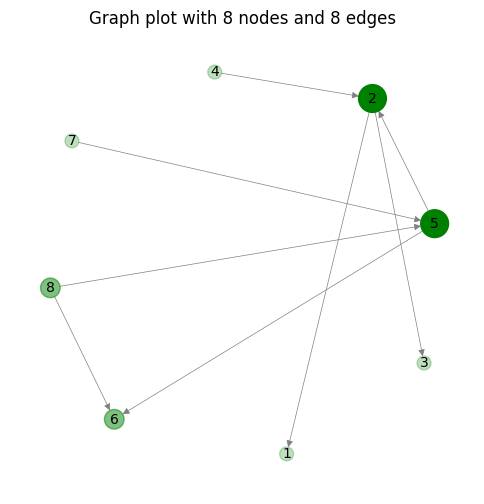

In [17]:
# plot graph -> node size and transparency: degree

plot_graph(graph, plot_all=True, figure_size=(6, 6))

In a directed cyclic graph, nodes can be categorized as either **ancestors** or **descendants**. An ancestor of a node *v* is a distinct node *u* from which we can trace a direct path leading to *v*. Conversely, node *v* is considered a descendant of node *u* in this context. Therefore, ancestors and descendants are positioned along a linear path, with ancestors preceding descendants in the graph's structure.

Ancestors of node 2: {8, 4, 5, 7}
Descendants of node 2: {1, 3}


/tmp/ipykernel_50347/213895213.py:64: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ax = nx.draw_networkx_edges(


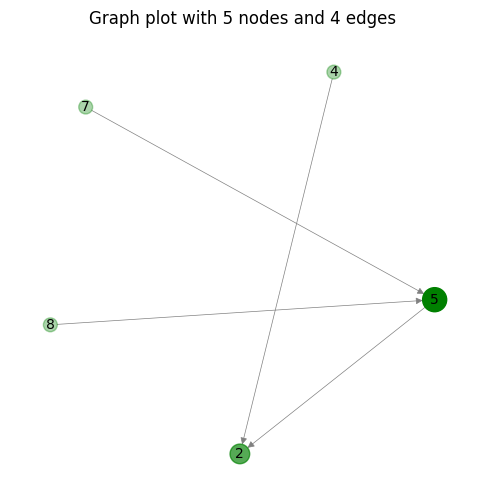

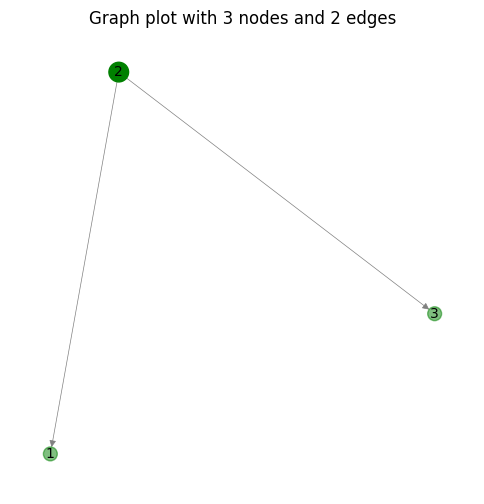

In [18]:
print(f"Ancestors of node 2: {nx.ancestors(graph, 2)}")
print(f"Descendants of node 2: {nx.descendants(graph, 2)}")

# plot ancestors of node 2
plot_graph(graph, plot_all=False, plot_nodes=[2, 8, 4, 5, 7], figure_size=(6, 6))

# plot descendants of node 2
plot_graph(graph, plot_all=False, plot_nodes=[2, 1, 3], figure_size=(6, 6))

it is possible to partition the directed graph into distinct layers known as **topological generations**. This process involves applying a topological sorting algorithm to the nodes in such a manner that a node within a given generation is guaranteed to have its ancestors located in the previous generation.

In [19]:
counter = 1
for item in nx.topological_generations(graph):
    print(f"Generation {counter}: {item}")
    counter += 1

Generation 1: [4, 7, 8]
Generation 2: [5]
Generation 3: [2, 6]
Generation 4: [1, 3]


Another interesting aspect of graphs is finding the **longest path between two nodes**. In graphs where edges have weights, we calculate the longest path by considering the **weighted node degree**. This essentially means adding up the importance of all the connections a node has.

In [20]:
print(
    f"Longest path of weighted graph: {nx.dag_longest_path(graph)} (lenght={len(nx.dag_longest_path(graph)) - 1})"
)


Longest path of weighted graph: [4, 2, 1] (lenght=2)


Removing the weights, the longest path between two nodes is the number of edges in the path between them.

In [21]:
# removing weights to calculate the longest path of an un-weighted graph

# copy a version of the original weighted graph
graph_unweighted = graph.copy()

# print out edges' attributes
print("Weighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])

# remove weights by accessing the graph data structure
for node, edges in nx.to_dict_of_dicts(graph_unweighted).items():
    for (
        edge,
        attrs,
    ) in edges.items():
        attrs.pop("weight", None)

print()

# print out edges' attributes (no weights)
print("Unweighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])


print(
    f"\nLongest path of unweighted graph: {nx.dag_longest_path(graph_unweighted)} (lenght={len(nx.dag_longest_path(graph_unweighted)) - 1})"
)


Weighted edges' attributes:
{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}

Unweighted edges' attributes:
{'attribute': 'is_a'}
{'attribute': 'regulates'}
{'attribute': 'activates'}
{'attribute': 'a random relation'}
{'attribute': 'is_a'}
{'attribute': 'deactivates'}
{'attribute': 'unknown'}
{'attribute': 'kick'}

Longest path of unweighted graph: [7, 5, 2, 1] (lenght=3)


## Exploratory Data Analysis - Gene Ontology Graph

### Reading and Parsing GO Graph Data

The GO graph is stored in the *OBO format*, which is specifically tailored for constructing and representing biological ontologies. To read and parse the GO graph, we utilize the Python library *obonet*, which allows us to convert it into a NetworkX object. This object provides a comprehensive toolkit for graph manipulation and analysis.

In the following section, we proceed to load and parse the GO graph to explore its basic features.

In [22]:
from obonet import read_obo

go_graph = read_obo(home_dir.joinpath("go-basic.obo"))
print(type(go_graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [23]:
print(
    f"Is Directed Acyclic Graph (DAG)?: {nx.is_directed_acyclic_graph(go_graph)}")
print(
    f"Is MultiGraph (multiple edges between two nodes)?: {go_graph.is_multigraph()}")
print(f"Is weighted graph: {nx.is_weighted(go_graph)}")
print(f"Number of Nodes: {go_graph.order()}")
print(f"Number of Edges: {go_graph.size()}")


Is Directed Acyclic Graph (DAG)?: True
Is MultiGraph (multiple edges between two nodes)?: True
Is weighted graph: False
Number of Nodes: 43248
Number of Edges: 84805


### Analyzing graph and nodes' degrees

The degree of each node is stored in a dictionary-like structure that can be retrieved as a list of tuples (GO term, degree) using the handy Python's list comprehension. Let's sort the nodes by descending order of degree. We use a lambda function to pass the node's degree as key for sorting and return an ordered list of tuples *(GO term, degree)*.

In [24]:
# print out degrees of top in-degree nodes
go_term_in_desc = sorted(go_graph.in_degree(), key=lambda x: x[1], reverse=True)

print("Degrees:\n")
for term in go_term_in_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )

Degrees:

Node: GO:0110165, in-degree: 424, out-degree: 1, degree: 425
Node: GO:0016616, in-degree: 348, out-degree: 1, degree: 349
Node: GO:0016709, in-degree: 291, out-degree: 2, degree: 293
Node: GO:0032991, in-degree: 274, out-degree: 1, degree: 275
Node: GO:0016758, in-degree: 208, out-degree: 1, degree: 209
Node: GO:0048856, in-degree: 202, out-degree: 1, degree: 203
Node: GO:0098797, in-degree: 181, out-degree: 2, degree: 183
Node: GO:0140513, in-degree: 173, out-degree: 2, degree: 175
Node: GO:0003006, in-degree: 172, out-degree: 2, degree: 174
Node: GO:0016747, in-degree: 163, out-degree: 1, degree: 164
Node: GO:0016836, in-degree: 158, out-degree: 1, degree: 159


In [25]:
# print out degrees of top in-degree nodes
go_term_out_desc = sorted(go_graph.out_degree(), key=lambda x: x[1], reverse=True)
for term in go_term_out_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )

Node: GO:0106110, in-degree: 0, out-degree: 11, degree: 11
Node: GO:0140872, in-degree: 0, out-degree: 10, degree: 10
Node: GO:0060520, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900498, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900499, in-degree: 0, out-degree: 9, degree: 9
Node: GO:0000514, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0009102, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0010439, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0034223, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0042367, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0043642, in-degree: 0, out-degree: 8, degree: 8


We can check the **degree distribution** of the network. Highly connected networks tend to be *symmetric*, i.e., closer to the *normal distribution*. 

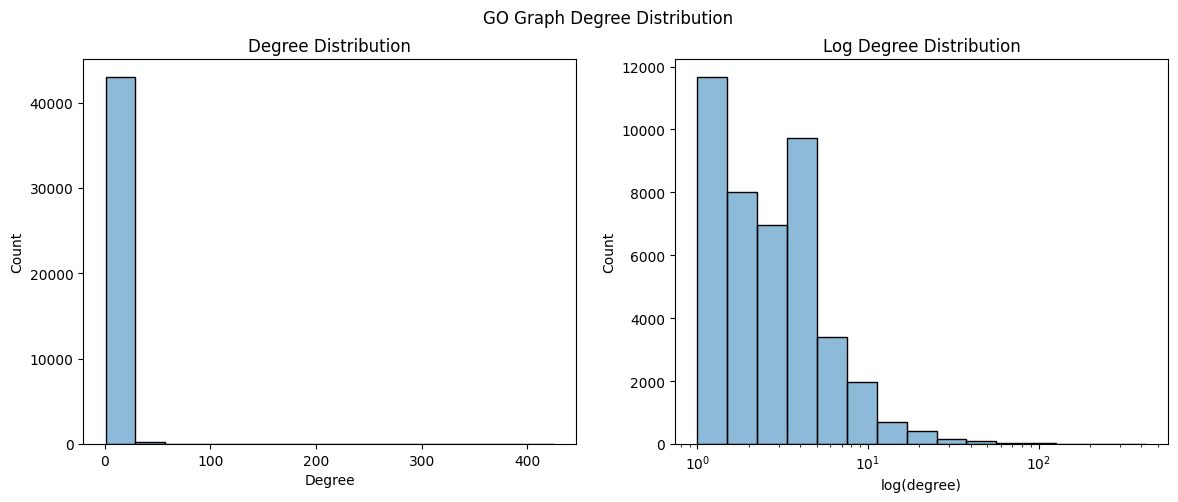

In [26]:
plot_hist_degree(go_graph, bins=15)

The distribution of degrees is *asymmetric* and has a *positive skewness*, meaning that most nodes lie *left* of the *mean* and have relatively small degrees.

In real networks, the majority of nodes have a small number of links, while there are a small number of nodes with high degree, which can be called ***hubs***. Hubs are highly connected nodes and can be seen as the most visited pages on the internet or celebrities in social networks.

We also define the *average degree* of the network, a general property of graphs that indicates how connected the nodes are. For example, if two social networks have the same number of nodes, the network with the higher average degree indicates that people in that network have more friends on average.

We can use `G.size()` and `G.order()` to find the number of edges and nodes respectively.

In [27]:
print(f"GO graph average degree: {(go_graph.size() / go_graph.order()):.2f}")

GO graph average degree: 1.96


The average degree of the GO graph is ~2, which means that the average number of edges per node is small. However, we see above that there are *hubs* with dozens or hundreds of connections, while more than 50% of the nodes have degree 3 or less. Examining such nodes and their attributes can be informative for machine learning tasks, as they have a greater impact on predicting new nodes or edges.

### Extracting and visualizing nodes' attributes

The nodes' attributes in the GO graph contain essential information about each term. To get a glimpse of this data, let's print out the attributes of a randomly selected node (yes, we're serious!). Feel free to continue running the cell to explore the attributes of each node in the GO graph one by one. It's a hands-on way to dive into the wealth of information this graph holds!

In [28]:
import random

go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'peptidyl-aspartic acid 3-dioxygenase activity',
 'namespace': 'molecular_function',
 'alt_id': ['GO:0004597'],
 'def': '"Catalysis of the reaction: protein L-aspartate + 2-oxoglutarate + O2 = protein 3-hydroxy-L-aspartate + succinate + CO2." [PMID:1378441, PMID:1856229, RHEA:11508]',
 'synonym': ['"aspartate beta-hydroxylase activity" RELATED [EC:1.14.11.16]',
  '"aspartyl/asparaginyl beta-hydroxylase activity" RELATED [EC:1.14.11.16]',
  '"aspartylpeptide beta-dioxygenase activity" RELATED [EC:1.14.11.16]',
  '"peptide-aspartate beta-dioxygenase activity" EXACT []',
  '"peptide-L-aspartate,2-oxoglutarate:oxygen oxidoreductase (3-hydroxylating) activity" RELATED [EC:1.14.11.16]'],
 'xref': ['EC:1.14.11.16',
  'MetaCyc:PEPTIDE-ASPARTATE-BETA-DIOXYGENASE-RXN',
  'RESID:AA0026',
  'RHEA:11508'],
 'is_a': ['GO:0016706', 'GO:0140096']}

In the node's attributes we can see some interesting features underlying each GO term. Here is a brief explanation about the essential GO term elements to describe and identify each GO term.

The *name* is a unique identifier of the term in a human-readable format.

The *namespace* is one of the three major ontologies to which the term belongs:

- <font color="grey">***Molecular Function (MF)***</font>: specify the activities performed by the gene product, which can be "catalysis", "transport", etc. These functions can be narrowed down by more specific GO terms. "protein kinase activity" is more specific than just "catalysis"


- <font color="grey">***Cellular Component (CC)***</font>: specify the subcellular location of the gene product, which includes compartments (e.g. 'chloroplast', 'nucleus') or macromolecular complexes such as the 'proteasome' or 'ribosome'.


- <font color="grey">***Biological Process (BP)***</font>: specify the biological pathways in which the gene product is involved. Examples are 'DNA repair', 'carbohydrate metabolic process', or more general processes such as 'byosynthetic process'.

The *definition* ('def') is a concise short description of  what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

Finally, the *relations* between GO terms is given by keys such as *'is_a'*, or *'regulates'*. It is a GO representation of how two entities (remember, nodes are entities ) are connected. There are other types of relations and we can bear in mind that the list of GO terms and the types of relations can grow overtime to accomodate precise definitions of new processes or new nuances regarding gene product's activities.

There are many additional attributes determined by the Gene Ontology Consortium, but the above ones are required to properly identify the GO term. By running the cell a couple of times you will see that the number of attributes vary but the four explained above are always there.


In the code cell bellow, we sort the nodes in descending order of degree and retrieve some of their attributes:


In [29]:
from itertools import islice

# get GO degrees into a dict
go_degree_desc_dict = {}
go_degree_desc_dict = tuple_to_dict(
    sorted(go_graph.degree, key=lambda x: x[1], reverse=True), go_degree_desc_dict
)

# getting only top nodes
top_nodes_dict = dict(islice(go_degree_desc_dict.items(), 6))

# and print the GO term names

term_list = []  # keeping the terms to get their neighborhood later

for key, value in top_nodes_dict.items():
    term_list.append(key)
    print(
        f"{key} (degree: {value}) -->  {go_graph.nodes()[key]['namespace']} | {go_graph.nodes()[key]['name']}"
    )

print(f"\nTop degree list: {term_list}")

GO:0110165 (degree: 425) -->  cellular_component | cellular anatomical entity
GO:0016616 (degree: 349) -->  molecular_function | oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor
GO:0016709 (degree: 293) -->  molecular_function | oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen
GO:0032991 (degree: 275) -->  cellular_component | protein-containing complex
GO:0016758 (degree: 209) -->  molecular_function | hexosyltransferase activity
GO:0048856 (degree: 203) -->  biological_process | anatomical structure development

Top degree list: ['GO:0110165', 'GO:0016616', 'GO:0016709', 'GO:0032991', 'GO:0016758', 'GO:0048856']


The terms have broad definitions about the type of cellular compartment, biological processe and molecular function they describe. As we move from parents to children terms we also narrow down more specific definitions. 

We can list all neighbors of a specific node. For directed graphs, the neighbors of a node are all of tis incoming and outcoming edges. Let's look at the neighborhood that can be found at ***one-hop*** distance (i.e. the immediate neighboring nodes).

In [30]:
hub = "GO:0110165"  # molecular function: oxidoreductase activity
hub_neighbors = [n for n in nx.all_neighbors(go_graph, hub)]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc[:25]:  # top 25
    print(f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]['namespace']} | {go_graph.nodes()[term[0]]['name']}")


Neighbors of GO:0110165 (cellular anatomical entity) in descending order of degree:

GO:0005737 (degree: 21) --> cellular_component | cytoplasm
GO:0042995 (degree: 9) --> cellular_component | cell projection
GO:0005576 (degree: 7) --> cellular_component | extracellular region
GO:0044304 (degree: 6) --> cellular_component | main axon
GO:0005930 (degree: 6) --> cellular_component | axoneme
GO:0009425 (degree: 5) --> cellular_component | bacterial-type flagellum basal body
GO:0020007 (degree: 5) --> cellular_component | apical complex
GO:0031672 (degree: 4) --> cellular_component | A band
GO:1990716 (degree: 4) --> cellular_component | axonemal central apparatus
GO:0043673 (degree: 4) --> cellular_component | sexine
GO:0009986 (degree: 4) --> cellular_component | cell surface
GO:0043209 (degree: 4) --> cellular_component | myelin sheath
GO:0043668 (degree: 4) --> cellular_component | exine
GO:0016020 (degree: 4) --> cellular_component | membrane
GO:0032153 (degree: 3) --> cellular_compone

Note that *cytoplasm*, *cell projection*, *extracelullar region*, etc., are still broad biological definitions and have a relativelly higher degree in comparison with the majority of nodes in the GO graph. For example, in the *extracelullar region* we have parent neighbors (*celullar anatomical entity*) and child terms that narrow the definitions of the extracellular region:

In [31]:
hub = "GO:0005576"
hub_neighbors = [n for n in nx.all_neighbors(go_graph, hub)]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc:
    print(f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]}")

Neighbors of GO:0005576 (extracellular region) in descending order of degree:

GO:0110165 (degree: 7) --> {'name': 'cellular anatomical entity', 'namespace': 'cellular_component', 'def': '"A part of a cellular organism that is either an immaterial entity or a material entity with granularity above the level of a protein complex but below that of an anatomical system. Or, a substance produced by a cellular organism with granularity above the level of a protein complex." [GOC:kmv]', 'is_a': ['GO:0005575']}
GO:0043245 (degree: 1) --> {'name': 'extraorganismal space', 'namespace': 'cellular_component', 'def': '"The environmental space outside of an organism; this may be a host organism in the case of parasitic and symbiotic organisms." [GOC:jl]', 'is_a': ['GO:0110165'], 'relationship': ['part_of GO:0005576']}
GO:0035183 (degree: 1) --> {'name': 'female germline ring canal inner rim', 'namespace': 'cellular_component', 'def': '"A proteinaceous actin-rich layer of the insect ovarian ring can

Navigating the GO graph is a breeze, thanks to its concise and well-structured data representation. What's even better, these data structures leverage standard Python libraries with minimal tweaks, making it a snap to switch between different data types with just a few lines of code.

### Analyzing graph connectivity

As we have seen above, connectivity measures the ability to traverse the graph from a node to another through a path. In highly connected graphs, a node can be reached from many others.

To apply the functions to access graph connectivity, we need to know if the graph is directed or undirected because the functions can be specific for each type:


In [32]:
print(f"Is Directed Acyclic Graph?: {nx.is_directed_acyclic_graph(go_graph)}")
print(f"Is Directed Acyclic Multigraph?: {go_graph.is_multigraph()}")

Is Directed Acyclic Graph?: True
Is Directed Acyclic Multigraph?: True


The GO graph is acyclic, which means it doesn't contain any cycles or loops in its structure. Additionally, it has multiple edges connecting the same two nodes. In the section below, we'll display the connectivity measures that are applicable to this graph. Further down, we'll delve into exploring paths within the graph.

In [33]:
print(
    f"Number of connected components: {nx.number_strongly_connected_components(go_graph)}"
)
print(f"Strongly connected?: {nx.is_strongly_connected(go_graph)}")
print(f"Semiconnected?: {nx.is_semiconnected(go_graph)}")
print(f"Weakly connected?: {nx.is_weakly_connected(go_graph)}")


Number of connected components: 43248
Strongly connected?: False
Semiconnected?: False
Weakly connected?: False


### Exploring Parents and Children GO terms

In the context of the Gene Ontology, GO terms are connected as *parent* and *child* nodes. To get a detailed overview of these relationships, you can refer to the [Relations in the Gene Ontology](https://geneontology.org/docs/ontology-relations/) documentation.

>In the GO Directed Acyclic MultiGraph, the terminology differs slightly from the traditional understanding of *parents* and *children* concerning the terminology used in graphs, where we have *ancestors* and *descendants*. Here, the nodes closer to the root of the tree within each ontology (Cellular Component, Molecular Function, and Biological Process) are considered the *parents* and referred as *descendants* in the graph, and *children* are closer to the terminal leaves and referred as *ancestors*. It's important to note that the direction of the edges in the GO graph is oriented from the leaves to the root. Consequently, in this context, the *parent terms are descendants*, and the *children terms are ancestors*.

With this understanding, we will proceed to print both the ancestors and descendants of the GO term GO:0110165.

In [34]:
go_term = "GO:0110165"
children = list(nx.ancestors(go_graph, go_term))
parents = list(nx.descendants(go_graph, go_term))

print(f"Children of {go_term}:")
for term in children[:10]:  #  printing only 10 terms because the list is large
    print(f"{term} --> {go_graph.nodes()[term]}")

print(f"\nParents of {go_term}:")
for term in parents:
    print(f"{term} --> {go_graph.nodes()[term]}")


Children of GO:0110165:
GO:0160045 --> {'name': 'TMEM240-body', 'namespace': 'cellular_component', 'def': '"A multilamellar subcellular structure formed in the cytoplasm of developing neuron, composed of Tmem240 and Emd proteins." [PMID:32535204]', 'synonym': ['"T240-body" EXACT []'], 'is_a': ['GO:0043231']}
GO:0034399 --> {'name': 'nuclear periphery', 'namespace': 'cellular_component', 'def': '"The portion of the nuclear lumen proximal to the inner nuclear membrane." [GOC:krc, GOC:mah]', 'is_a': ['GO:0110165'], 'relationship': ['part_of GO:0031981']}
GO:0061827 --> {'name': 'sperm head', 'namespace': 'cellular_component', 'def': '"The part of the late spermatid or spermatozoon that contains the nucleus and acrosome." [PMID:22797892, PMID:24665388]', 'is_a': ['GO:0110165']}
GO:0045246 --> {'name': 'cytosolic tricarboxylic acid cycle enzyme complex', 'namespace': 'cellular_component', 'def': '"Any of the heteromeric enzymes, located in the cytosol, that act in the tricarboxylic acid (TC

>**Topological Generations**: Given that the GO graph is structured as a directed acyclic graph, it can be divided into distinct **topological generations**. As we've observed previously, the GO graph comprises three basal ontologies, each forming a separate tree. Each of these ontologies serve as root for all its children terms, encompassing all the terms further down the hierarchy. In the code cell below, we extract and display the topological generations of the entire GO graph. We list the items followed by their respective major ontology.

<font color="grey"><b>Note:</b> The function limits the number of items in large generations for printing.

In [35]:
print_generations(go_graph)

Generation 19 -> ['GO:0000001 (biological_process)', 'GO:0000006 (molecular_function)', 'GO:0000007 (molecular_function)', 'GO:0000010 (molecular_function)', 'GO:0000011 (biological_process)', 'GO:0000015 (cellular_component)', 'GO:0000016 (molecular_function)', 'GO:0000017 (biological_process)', 'GO:0000024 (biological_process)', 'GO:0000025 (biological_process)', 'GO:0000031 (molecular_function)']
Generation 18 -> ['GO:0000023 (biological_process)', 'GO:0006057 (biological_process)', 'GO:0031506 (biological_process)', 'GO:0044620 (molecular_function)', 'GO:0051329 (biological_process)', 'GO:0000090 (biological_process)', 'GO:0015191 (molecular_function)', 'GO:0046219 (biological_process)', 'GO:0033181 (cellular_component)', 'GO:0015131 (molecular_function)', 'GO:0007128 (biological_process)']
Generation 17 -> ['GO:0006056 (biological_process)', 'GO:0051192 (molecular_function)', 'GO:0051322 (biological_process)', 'GO:0000087 (biological_process)', 'GO:0043865 (molecular_function)', '

The terms found in *Generation 19* are guaranteed to have ancestors in the preceding generations, although some terms may skip certain intermediate generations.

The resulting output resembles the [ancestor chart](https://www.ebi.ac.uk/sites/ebi.ac.uk/files/groups/uniprot/posters/QuickGo_Biocuration.pdf) accessible in [QuickGo](https://www.ebi.ac.uk/QuickGO/annotations). It's important to note that the most foundational generation corresponds to the most general term within the entire GO graph. In subsequent steps, we will obtain the generations specific to Cellular Component, Molecular Function and Biological Process.

>**Path Length**: The stratified topological generations discussed above are invaluable for gaining insight into the hierarchical organization of the graph, delineating relationships between parent and child terms. Additionally, within this structure, we can pinpoint the **longest path length** within the tree. This represents the path consisting of terms that constitute the lengthiest sequence of ancestors and descendants in the graph.

Given that we have identified 19 generations in the GO graph, we can anticipate that the longest path will consist of (Generation - 1) edges.

In [36]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph)}\n")

for item in nx.dag_longest_path(go_graph):
    print(
        f"{item}: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )


GO terms in the longest path (order: terminal leaves -> root):
Path length: 18

GO:0090687: activation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905326: positive regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905325: regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905318: meiosis I spindle assembly checkpoint signaling | Ontology: biological_process
GO:0033316: meiotic spindle assembly checkpoint signaling | Ontology: biological_process
GO:0044779: meiotic spindle checkpoint signaling | Ontology: biological_process
GO:1902103: negative regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
GO:1902102: regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
GO:1905132: regulation of meiotic chromosome separation | Ontology: biological_process
GO:0051307: meiotic chromosome separation | Ontology

### Spliting the GO graph into major ontologies

We can split the GO graph into three sub-graphs corresponding to the major ontologies. I did it by iterating over two 'carbon-copies' of the entire GO graph and removing nodes from the copy using a conditional statement. Maybe there is an way easier way but I couldn't find it.

In [37]:
# initialize ontologies graphs by copying the entire GO graph
go_graph_cc = go_graph.copy()
go_graph_bp = go_graph.copy()
go_graph_mf = go_graph.copy()

# CC
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "cellular_component":
        go_graph_cc.remove_node(term)

# BP
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "biological_process":
        go_graph_bp.remove_node(term)

# MF
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "molecular_function":
        go_graph_mf.remove_node(term)


print(
    f"CC sub-graph --> nodes: {go_graph_cc.order()}, edges: {go_graph_cc.size()}")
print(
    f"BP sub-graph --> nodes: {go_graph_bp.order()}, edges: {go_graph_bp.size()}")
print(
    f"MF sub-graph --> nodes: {go_graph_mf.order()}, edges: {go_graph_mf.size()}")


CC sub-graph --> nodes: 4043, edges: 6498
BP sub-graph --> nodes: 27942, edges: 64560
MF sub-graph --> nodes: 11263, edges: 13747


With these counts of nodes and edges we can infer some interesting insights. We can check the average degrees and rank nodes' degrees in each graph. This will allow us to determine their hubs considering only one ontology at a time.

CC sub-graph average degree: 1.61


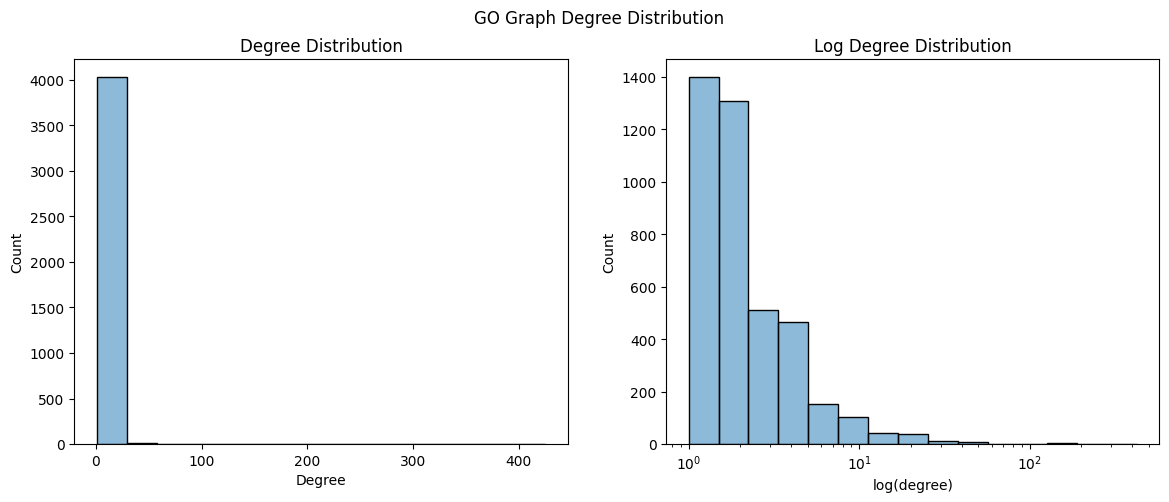

In [38]:
# Cellular Component

print(f"CC sub-graph average degree: {(go_graph_cc.size() / go_graph_cc.order()):.2f}")

plot_hist_degree(go_graph_cc)

MF sub-graph average degree: 1.22


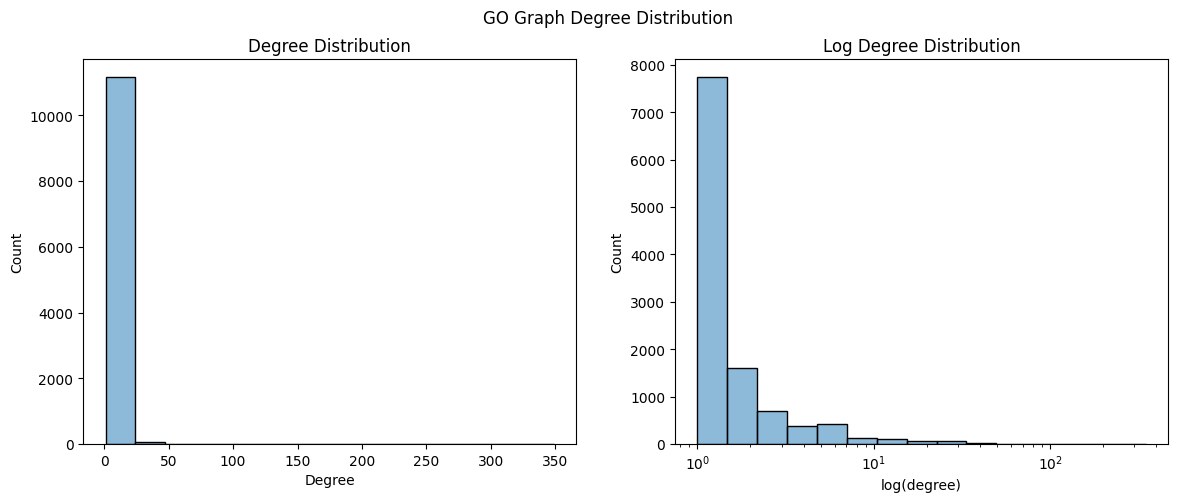

In [39]:
# Molecular Function

print(f"MF sub-graph average degree: {(go_graph_mf.size() / go_graph_mf.order()):.2f}")

plot_hist_degree(go_graph_mf)

BP sub-graph average degree: 2.31


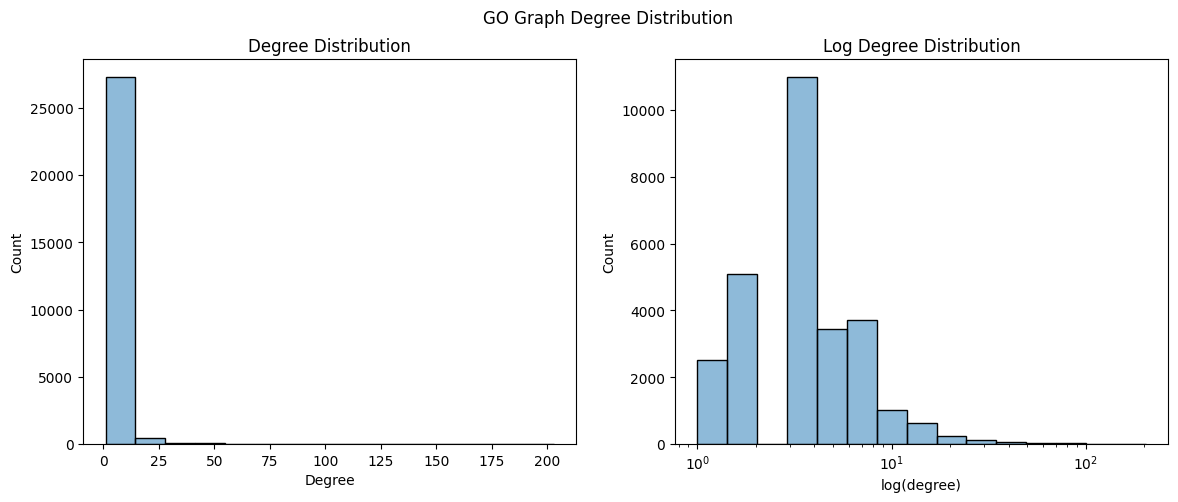

In [40]:
# Biological Process

print(f"BP sub-graph average degree: {(go_graph_bp.size() / go_graph_bp.order()):.2f}")

plot_hist_degree(go_graph_bp)

The degree distribution of the ontologies Cellular Component and Molecular Function exhibits fairly similar patterns. However, nodes corresponding to the Biological Process ontology display a notable prevalence of higher degrees when compared to Cellular Component and Molecular Function. This increased connectivity in Biological Process nodes may be attributed to the inherent complexity and interconnectedness of biological processes.

Biological processes often involve intricate pathways with numerous enzymatic steps, cross-talk between pathways, and overlapping components of different processes. For instance, consider glucose metabolism, which serves as the entry point for energy metabolism and provides substrates for various biosynthetic reactions. This interplay and interconnectedness within biological processes can contribute to higher degrees in the graph.

Now, let's explore the topological generations of the sub-graphs and observe how they contrast with the structure of the original GO graph.

In [41]:
print("Topological Generations -> Cellular Component")
print_generations(go_graph_cc)

Topological Generations -> Cellular Component
Generation 15 -> ['GO:0000015 (cellular_component)', 'GO:0000110 (cellular_component)', 'GO:0000111 (cellular_component)', 'GO:0000113 (cellular_component)', 'GO:0000124 (cellular_component)', 'GO:0000131 (cellular_component)', 'GO:0000142 (cellular_component)', 'GO:0000145 (cellular_component)', 'GO:0000148 (cellular_component)', 'GO:0000159 (cellular_component)', 'GO:0000172 (cellular_component)']
Generation 14 -> ['GO:0033181 (cellular_component)', 'GO:0042645 (cellular_component)', 'GO:0000276 (cellular_component)', 'GO:0000324 (cellular_component)', 'GO:0000427 (cellular_component)', 'GO:0000439 (cellular_component)', 'GO:0000112 (cellular_component)', 'GO:0000346 (cellular_component)', 'GO:0000347 (cellular_component)', 'GO:0000795 (cellular_component)', 'GO:0000836 (cellular_component)']
Generation 13 -> ['GO:0000109 (cellular_component)', 'GO:0099086 (cellular_component)', 'GO:0000835 (cellular_component)', 'GO:0098648 (cellular_com

In [42]:
print("Topological Generations -> Molecular Function")
print_generations(go_graph_mf)

Topological Generations -> Molecular Function
Generation 13 -> ['GO:0000006 (molecular_function)', 'GO:0000007 (molecular_function)', 'GO:0000010 (molecular_function)', 'GO:0000016 (molecular_function)', 'GO:0000031 (molecular_function)', 'GO:0000034 (molecular_function)', 'GO:0000035 (molecular_function)', 'GO:0000036 (molecular_function)', 'GO:0000048 (molecular_function)', 'GO:0000095 (molecular_function)', 'GO:0000100 (molecular_function)']
Generation 12 -> ['GO:0044620 (molecular_function)', 'GO:0015191 (molecular_function)', 'GO:0015131 (molecular_function)', 'GO:0019534 (molecular_function)', 'GO:0000497 (molecular_function)', 'GO:0000400 (molecular_function)', 'GO:0045183 (molecular_function)', 'GO:0080084 (molecular_function)', 'GO:0000992 (molecular_function)', 'GO:0001050 (molecular_function)', 'GO:0001000 (molecular_function)']
Generation 11 -> ['GO:0051192 (molecular_function)', 'GO:0043865 (molecular_function)', 'GO:0140489 (molecular_function)', 'GO:0001016 (molecular_fu

In [43]:
print("Topological Generations -> Biological Process")
print_generations(go_graph_bp)

Topological Generations -> Biological Process
Generation 19 -> ['GO:0000001 (biological_process)', 'GO:0000011 (biological_process)', 'GO:0000017 (biological_process)', 'GO:0000024 (biological_process)', 'GO:0000025 (biological_process)', 'GO:0000032 (biological_process)', 'GO:0000050 (biological_process)', 'GO:0000053 (biological_process)', 'GO:0000080 (biological_process)', 'GO:0000084 (biological_process)', 'GO:0000085 (biological_process)']
Generation 18 -> ['GO:0000023 (biological_process)', 'GO:0006057 (biological_process)', 'GO:0031506 (biological_process)', 'GO:0051329 (biological_process)', 'GO:0000090 (biological_process)', 'GO:0046219 (biological_process)', 'GO:0007128 (biological_process)', 'GO:0000387 (biological_process)', 'GO:0000320 (biological_process)', 'GO:0000754 (biological_process)', 'GO:0000337 (biological_process)']
Generation 17 -> ['GO:0006056 (biological_process)', 'GO:0051322 (biological_process)', 'GO:0000087 (biological_process)', 'GO:0051324 (biological_p

We can inspect the longest path length for each major ontology as we did above for the complete GO graph:

In [44]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_cc)}\n")

for item in nx.dag_longest_path(go_graph_cc):
    print(
        f"{item}: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )


GO terms in the longest path (order: terminal leaves -> root):
Path length: 14

GO:0030085: PSII associated light-harvesting complex II, peripheral complex, LHCIIb subcomplex | Ontology: cellular_component
GO:0009656: PSII associated light-harvesting complex II, peripheral complex | Ontology: cellular_component
GO:0009517: PSII associated light-harvesting complex II | Ontology: cellular_component
GO:0009503: thylakoid light-harvesting complex | Ontology: cellular_component
GO:0098807: chloroplast thylakoid membrane protein complex | Ontology: cellular_component
GO:0009535: chloroplast thylakoid membrane | Ontology: cellular_component
GO:0055035: plastid thylakoid membrane | Ontology: cellular_component
GO:0042170: plastid membrane | Ontology: cellular_component
GO:0009526: plastid envelope | Ontology: cellular_component
GO:0009536: plastid | Ontology: cellular_component
GO:0043231: intracellular membrane-bounded organelle | Ontology: cellular_component
GO:0043229: intracellular organel

In [45]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_mf)}\n")

for item in nx.dag_longest_path(go_graph_mf):
    print(
        f"{item}: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )


GO terms in the longest path (order: terminal leaves -> root):
Path length: 12

GO:0098697: ryanodine-sensitive calcium-release channel activity involved in regulation of postsynaptic cytosolic calcium levels | Ontology: molecular_function
GO:0005219: ryanodine-sensitive calcium-release channel activity | Ontology: molecular_function
GO:0015278: calcium-release channel activity | Ontology: molecular_function
GO:0099604: ligand-gated calcium channel activity | Ontology: molecular_function
GO:0099094: ligand-gated monoatomic cation channel activity | Ontology: molecular_function
GO:0015276: ligand-gated monoatomic ion channel activity | Ontology: molecular_function
GO:0022839: monoatomic ion gated channel activity | Ontology: molecular_function
GO:0005216: monoatomic ion channel activity | Ontology: molecular_function
GO:0015267: channel activity | Ontology: molecular_function
GO:0022803: passive transmembrane transporter activity | Ontology: molecular_function
GO:0022857: transmembrane 

In [46]:
print("GO terms in the longest path (order: terminal leaves -> root):")
print(f"Path length: {nx.dag_longest_path_length(go_graph_bp)}\n")

for item in nx.dag_longest_path(go_graph_bp):
    print(
        f"{item}: {go_graph.nodes()[item]['name']} | Ontology: {go_graph.nodes()[item]['namespace']}"
    )


GO terms in the longest path (order: terminal leaves -> root):
Path length: 18

GO:0090687: activation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905326: positive regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905325: regulation of meiosis I spindle assembly checkpoint | Ontology: biological_process
GO:1905318: meiosis I spindle assembly checkpoint signaling | Ontology: biological_process
GO:0033316: meiotic spindle assembly checkpoint signaling | Ontology: biological_process
GO:0044779: meiotic spindle checkpoint signaling | Ontology: biological_process
GO:1902103: negative regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
GO:1902102: regulation of metaphase/anaphase transition of meiotic cell cycle | Ontology: biological_process
GO:1905132: regulation of meiotic chromosome separation | Ontology: biological_process
GO:0051307: meiotic chromosome separation | Ontology

We can generate a visualization of the graph to gain a general understanding of its structure. However, it's important to note that graphs used in machine learning applications are often quite large, and attempting to plot all nodes and edges can be computationally intensive and less informative. To address this, we can utilize a custom function called `plot_graph`, which allows us to specify a subset of nodes for plotting. In this case, we will focus on plotting nodes with the highest degrees. 

The function adjusts the size and transparency of nodes based on their relative degrees. Given the immense size of the GO graph, selecting a subset of nodes is essential to maintain efficiency during visualization. Additionally, we can specify the number of iterations for determining the optimal node spacing. The [spring_layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html) algorithm in NetworkX models edges as springs that draw nodes closer together, while nodes themselves act as repelling objects. The simulation typically stops when these forces and positions reach equilibrium or when a predetermined number of iterations is reached.

Let's proceed to plot the ontology graphs for visualization.

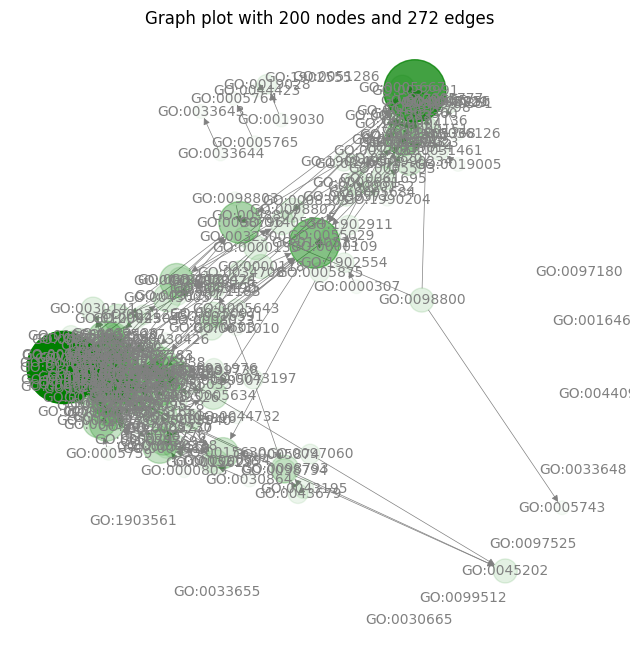

In [47]:
# Cellular Component network plot (highest degrees)

plot_graph(
    go_graph_cc,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_cc.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
    font_color="grey"
)

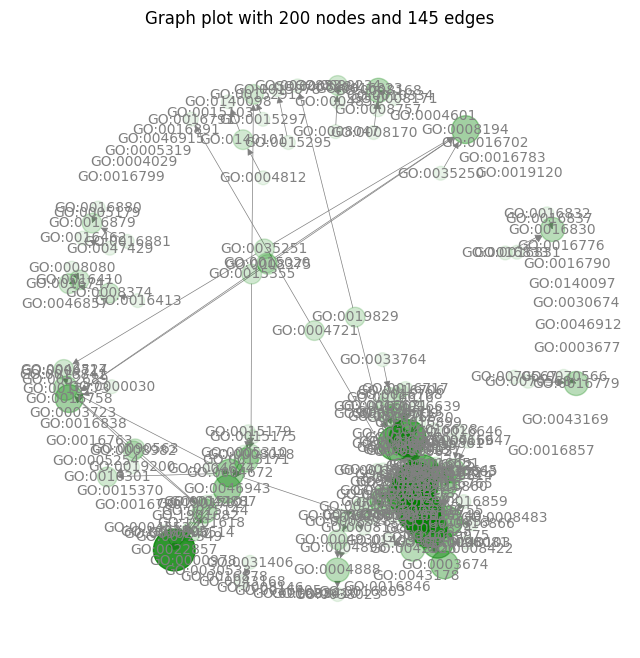

In [48]:
# Molecular Function network plot (highest degrees)

plot_graph(
    go_graph_mf,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_mf.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
    font_color="grey"
)

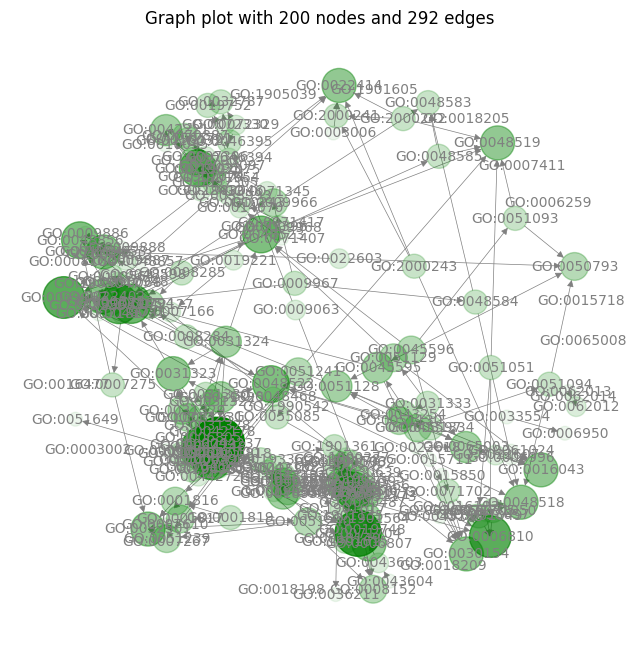

In [49]:
# Biological Process network plot (highest degrees)

plot_graph(
    go_graph_bp,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_bp.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
    font_color="grey"
)

Plotting the graphs, we can clearly see how biological processes are interconnected, which correlates with the highest average degree of the biological process graph. This is an important feature of the GO graph that might be relevant in machine learning applications, such as the prediction of protein function by assigning GO terms.

### Converting the GO terms attributes into a Pandas Dataframe

You might want to extract GO graph attributes into a dataframe. Dataframes are commom data structures in machine learning and are easier to manipulate and analyze because there are plenty of libraries and snipets to help in this task. We lose the topological information about the data but manipulating the dataset with Pandas can be useful (and easier) sometimes. Just a few lines of code do the job:

In [50]:
import pandas as pd

# creating a list with GO term definitions (the magic of list comprehension)
go_def_list = [go_graph.nodes()[term] for term in go_graph.nodes()]

# add features
go_df = pd.DataFrame.from_dict(go_def_list, orient="columns")

# insert column with GO term IDs (ordered)
go_df.insert(0, "go_term", list(go_graph.nodes()))

print(f"GO dataframe shape: {go_df.shape}")
go_df.head()


GO dataframe shape: (43248, 11)


,go_term,name,namespace,def,synonym,is_a,alt_id,subset,xref,relationship,comment
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]","[GO:0048308, GO:0048311]",NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,[GO:0007005],NaN,NaN,NaN,NaN,NaN
2,GO:0000003,reproduction,biological_process,"""The production of new individuals that contai...","[""reproductive physiological process"" EXACT []]",[GO:0008150],"[GO:0019952, GO:0050876]","[goslim_agr, goslim_chembl, goslim_flybase_rib...",[Wikipedia:Reproduction],NaN,NaN
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",[GO:0005385],NaN,NaN,NaN,NaN,NaN
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,[GO:0005385],NaN,NaN,NaN,NaN,NaN


Looking at the definition of GO terms, we see that 'name', 'namespace' and 'def' are commont to all GO term nodes, but there are more items in the GO terms nodes that are not. These will result in NaN (Not a Number) in the dataframe. We can get rid of it or replace by a more useful value. We can also add other informations to the dataframe such as degrees of nodes, embeddings of the text information (the term definitions, for example), or we can also merge other gene or protein-related datasets such as from BioGRID (protein-protein interactions) or UniProt (functional annotation of proteins)...

## Conclusion

Effective data visualization techniques may sometimes seem unconventional, but they can yield valuable insights into your data. There exists a multitude of tools that can be combined and customized to uncover hidden patterns and essential features within your samples and variables.

In our upcoming tutorial, we will extract the definitions of each GO term to serve as input for a pre-trained Large Language Model (LLM). This will enable us to enhance the feature representation of nodes by embedding their definitions into vectors. Our motivation lies in the potential of this approach to capture crucial information for refining the classification of GO terms.

Furthermore, as a supplementary analysis, we will employ the embedding of GO term definitions to project the extracted features into a manifold using T-SNE (t-Distributed Stochastic Neighbor Embedding). This will allow us to assess whether these embeddings are sufficiently informative to classify GO terms into major ontologies such as Cellular Compartment (CC), Biological Process (BP), and Molecular Function (MF).